<a href="https://colab.research.google.com/github/thiagotandrade/ds_project/blob/master/DS_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO: 
- Escolher as melhores features (usar XGBoost, ver correlação entre variáveis e alvo).

# Projeto 1 da Disciplina Data Science 2019.1, CIn - UFPE
# Competição do Kaggle: [Zillow Prize](https://www.kaggle.com/c/zillow-prize-1)

## Configurando ambiente

### Instalando Bibliotecas

In [1]:
!pip install missingpy
!pip install pyspark

### Imports

In [0]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import QuantileDiscretizer
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest


In [0]:
sc = SparkContext('local')
spark = SparkSession(sc)
pd.options.mode.chained_assignment = None
sns.set(style="ticks")
%matplotlib inline

In [0]:
# Variável para indicar se a imputação já foi feita anteriormente (salvar tempo de processamento)
imputed = True

### Lendo versão 2016 dos arquivos CSV

In [0]:
props = pd.read_csv('https://raw.githubusercontent.com/thiagotandrade/ds_project/master/Database/merged_2016v2.csv',
                    header=0, sep=',', quotechar='"')
props_bkp = props.copy()

## 2. Pré-processamento dos dados

In [6]:
props.tail().transpose()

,90270,90271,90272,90273,90274
parcelid,11876798,12808516,12010248,14310905,14636609
airconditioningtypeid,1,NaN,1,NaN,NaN
architecturalstyletypeid,NaN,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN,NaN
bathroomcnt,3,2,2,2.5,2.5
bedroomcnt,4,3,2,3,3
buildingclasstypeid,NaN,NaN,NaN,NaN,NaN
buildingqualitytypeid,4,7,4,NaN,NaN
calculatedbathnbr,3,2,2,2.5,2.5
decktypeid,NaN,NaN,NaN,NaN,NaN


In [7]:
props.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,9.027500e+04,28781.000000,261.000000,43.000000,90275.000000,90275.000000,16.0,57364.000000,89093.000000,658.0,...,89519.000000,20570.000000,8.989500e+04,9.027400e+04,90275.0,9.027400e+04,90269.000000,1783.000000,8.967000e+04,90275.000000
mean,1.298466e+07,1.816372,7.229885,713.581395,2.279474,3.031869,4.0,5.565407,2.309216,66.0,...,1968.532870,1.440739,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,13.402692,6.049151e+13,0.011457
std,2.504510e+06,2.974168,2.716196,437.434198,1.004271,1.156436,0.0,1.900602,0.976172,0.0,...,23.763475,0.544498,2.091299e+05,5.548844e+05,0.0,4.004955e+05,6838.876956,2.715966,2.046605e+11,0.161079
min,1.071174e+07,1.000000,2.000000,100.000000,0.000000,0.000000,4.0,1.000000,1.000000,66.0,...,1885.000000,1.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,6.000000,6.037101e+13,-4.605000
25%,1.155950e+07,1.000000,7.000000,407.500000,2.000000,2.000000,4.0,4.000000,2.000000,66.0,...,1953.000000,1.000000,8.124500e+04,1.990232e+05,2015.0,8.222800e+04,2872.830000,13.000000,6.037320e+13,-0.025300
50%,1.254734e+07,1.000000,7.000000,616.000000,2.000000,3.000000,4.0,7.000000,2.000000,66.0,...,1970.000000,1.000000,1.320000e+05,3.428720e+05,2015.0,1.929700e+05,4542.750000,14.000000,6.037615e+13,0.006000
75%,1.422755e+07,1.000000,7.000000,872.000000,3.000000,4.000000,4.0,7.000000,3.000000,66.0,...,1987.000000,2.000000,2.105345e+05,5.405890e+05,2015.0,3.454195e+05,6901.090000,15.000000,6.059042e+13,0.039200
max,1.629608e+08,13.000000,21.000000,1555.000000,20.000000,16.000000,4.0,12.000000,20.000000,66.0,...,2015.000000,4.000000,9.948100e+06,2.775000e+07,2015.0,2.450000e+07,321936.090000,99.000000,6.111009e+13,4.737000


In [0]:
# Não faz Sentido

# Inserir valor true na coluna 'fireplaceflag' se houve algum valor presente em fireplacecnt diferente de zero ou NaN
#props.loc[props['fireplacecnt'] != 0 | pd.notnull(props['fireplacecnt']),'fireplaceflag'] = "True"

### 2.1 Definição de tipos

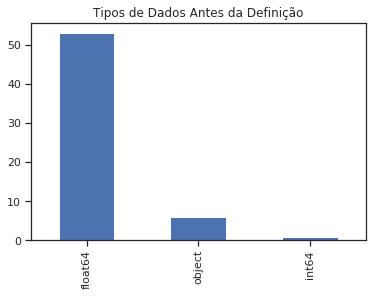

In [9]:
props_dtypes_before = props.dtypes.value_counts().sort_values(ascending=False)
props_dtypes_before.plot.bar(title='Tipos de Dados Antes da Definição')

In [0]:
# Mudando colunas de tipo 'object' para tipo 'category'
object_type = props.select_dtypes(include=['object']).columns.values
props[object_type] = props[object_type].astype('category')

#Mudar tipo da coluna transaction date para 'datetime64' e separando a data em colunas
props['transactiondate'] = pd.to_datetime(props['transactiondate'])
props['transaction_year'] = props['transactiondate'].dt.year
props['transaction_month'] = props['transactiondate'].dt.month
props['transaction_day'] = props['transactiondate'].dt.day
props.drop(['transactiondate'], axis=1, inplace=True)

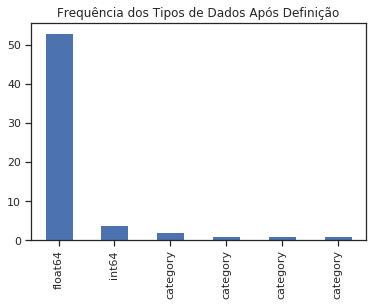

In [11]:
props_dtypes_after = props.dtypes.value_counts().sort_values(ascending=False)
props_dtypes_after.plot.bar(title='Frequência dos Tipos de Dados Após Definição')

### 2.2 Tratamento de dados ausentes

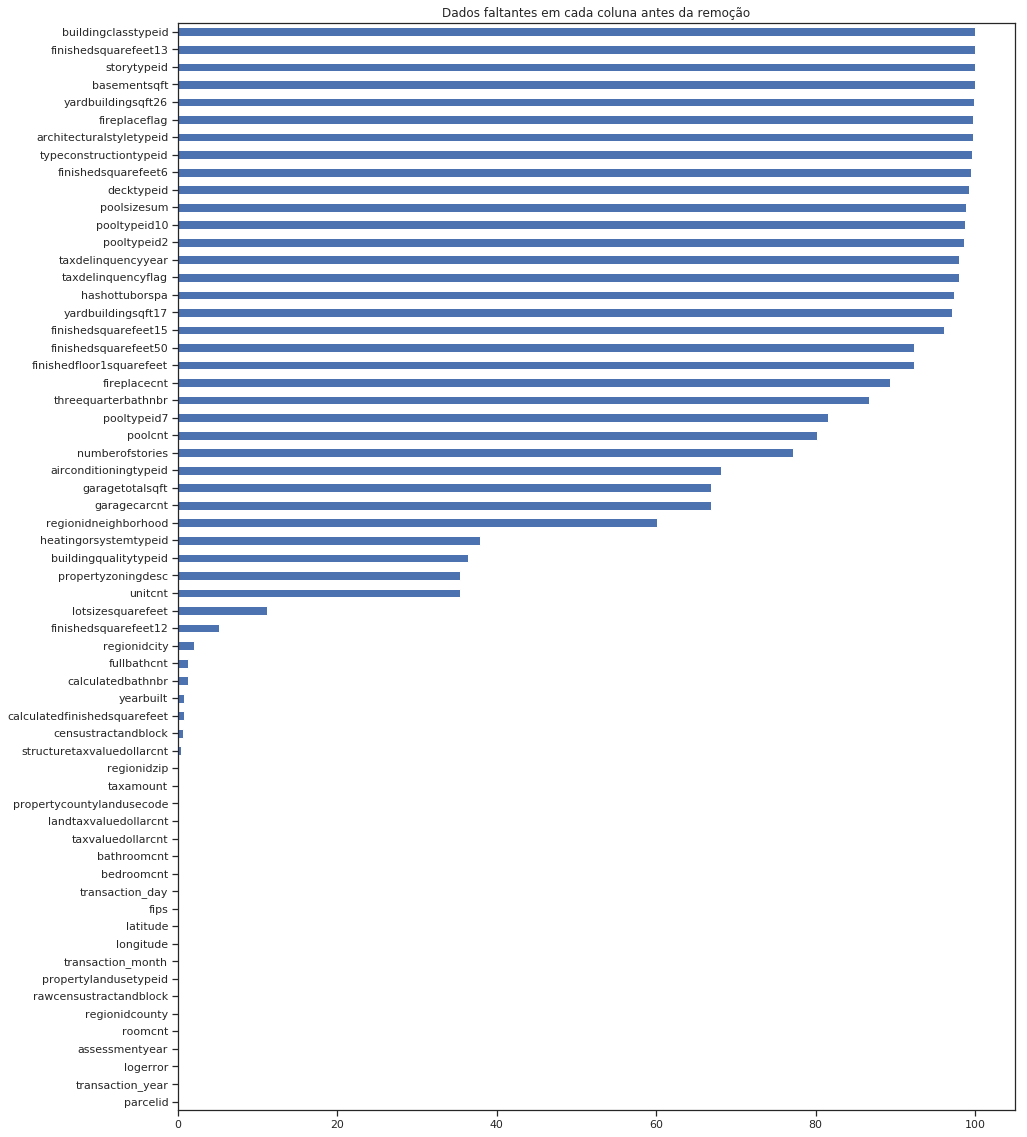

In [12]:
((props.isnull().sum()/len(props))*100).sort_values().plot.barh(figsize=(15,20), title='Dados faltantes em cada coluna antes da remoção')

#missingValueColumns = props.columns[props.isnull().any()].tolist()
#msno.bar(props[missingValueColumns])

#### 2.2.1 Remoção de dados

In [13]:
props.shape

(90275, 62)

##### Remoção de Instâncias

In [0]:
#df.dropna(thresh=2)   #Drop row if it does not have at least two values that are **not** NaN

# Remover linhas com mais de 70% de dados ausentes
props.dropna(thresh=(0.3*len(props.columns.values)), inplace=True)

##### Remoção de colunas

In [15]:
# A coluna 'assessmentyear' sempre tem o mesmo valor para todas as instâncias, logo se torna inútil mantê-la
print(props['assessmentyear'].value_counts())
props.drop(['assessmentyear'], axis=1, inplace=True)

2015.0    90275
Name: assessmentyear, dtype: int64


In [0]:
#A coluna 'fireplaceflag' não adiciona nenhuma informação útil pois o dataset já possui 'fireplacecnt', então removemos:
props.drop(['fireplaceflag'], axis=1, inplace=True)

#A coluna 'calculatedbathnbr' é uma cópia da coluna 'bathroomcnt', então removemos:
props.drop(['calculatedbathnbr'], axis=1, inplace=True)

#A coluna 'calculatedfinishedsquarefeet' é uma cópia da coluna 'finishedsquarefeet12', então removemos:
props.drop(['calculatedfinishedsquarefeet'], axis=1, inplace=True)

# Remover colunas com mais de 70% de dados ausentes
props.dropna(thresh=0.70*len(props), axis=1, inplace=True)

##### Dataframe Resultante

In [17]:
print('Dataframe Resultante: \n', props.shape)

props.head().transpose()

Dataframe Resultante: 
 (90275, 26)


,0,1,2,3,4
parcelid,17073783,17088994,17100444,17102429,17109604
bathroomcnt,2.5,1,2,1.5,2.5
bedroomcnt,3,2,3,2,4
finishedsquarefeet12,1264,777,1101,1554,2415
fips,6111,6111,6111,6111,6111
fullbathcnt,2,1,2,1,2
latitude,3.43036e+07,3.42729e+07,3.43408e+07,3.43543e+07,3.42666e+07
longitude,-1.19287e+08,-1.19199e+08,-1.1908e+08,-1.19076e+08,-1.19165e+08
lotsizesquarefeet,1735,NaN,6569,7400,6326
propertycountylandusecode,1128,1129,1111,1110,1111


In [18]:
nan_series_cols = props.isnull().sum()
print('Quantitativo de dados faltantes por coluna: \n')
nan_series_cols[nan_series_cols != 0].sort_values()
#nan_series_cols[nan_series_cols != 0].sort_values().plot.barh(figsize=(7,7), title='Quantidade de dados faltantes para as colunas que possuem')

Quantitativo de dados faltantes por coluna: 



propertycountylandusecode         1
taxvaluedollarcnt                 1
landtaxvaluedollarcnt             1
taxamount                         6
regionidzip                      35
structuretaxvaluedollarcnt      380
censustractandblock             605
yearbuilt                       756
fullbathcnt                    1182
regionidcity                   1803
finishedsquarefeet12           4679
lotsizesquarefeet             10150
dtype: int64

#### 2.2.2 Imputação de dados

[Obtendo colunas que contém valores NaN](https://dzone.com/articles/pandas-find-rows-where-columnfield-is-null)

In [0]:
nan_columns = props.columns[props.isnull().any()]

In [20]:
props[nan_columns].describe()

,finishedsquarefeet12,fullbathcnt,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock
count,85596.000000,89093.000000,8.012500e+04,88472.000000,90240.000000,89519.000000,8.989500e+04,9.027400e+04,9.027400e+04,90269.000000,8.967000e+04
mean,1745.454531,2.241231,2.911016e+04,33761.332851,96586.131184,1968.532870,1.800934e+05,4.576726e+05,2.783353e+05,5983.975927,6.049151e+13
std,909.941166,0.963142,1.217213e+05,46672.393863,3661.339094,23.763475,2.091299e+05,5.548844e+05,4.004955e+05,6838.876956,2.046605e+11
min,2.000000,1.000000,1.670000e+02,3491.000000,95982.000000,1885.000000,1.000000e+02,2.200000e+01,2.200000e+01,49.080000,6.037101e+13
25%,1172.000000,2.000000,5.703000e+03,12447.000000,96193.000000,1953.000000,8.124500e+04,1.990232e+05,8.222800e+04,2872.830000,6.037320e+13
50%,1518.000000,2.000000,7.200000e+03,25218.000000,96393.000000,1970.000000,1.320000e+05,3.428720e+05,1.929700e+05,4542.750000,6.037615e+13
75%,2056.000000,3.000000,1.168600e+04,45457.000000,96987.000000,1987.000000,2.105345e+05,5.405890e+05,3.454195e+05,6901.090000,6.059042e+13
max,20013.000000,20.000000,6.971010e+06,396556.000000,399675.000000,2015.000000,9.948100e+06,2.775000e+07,2.450000e+07,321936.090000,6.111009e+13


##### Dados Categóricos

In [0]:
cat_df_nan = props[nan_columns].select_dtypes(include=['category']).copy()

In [22]:
cat_df_nan.head()

,propertycountylandusecode
0,1128
1,1129
2,1111
3,1110
4,1111


In [23]:
print('Total NaN values in categorical columns: ' + str(cat_df_nan.isnull().values.sum()))
print(cat_df_nan.isnull().sum())

Total NaN values in categorical columns: 1
propertycountylandusecode    1
dtype: int64


In [0]:
category_type = props.select_dtypes(include=['category']).columns.values
for c in category_type:
  props[c] = props[c].cat.codes

##### Dados Numéricos

In [0]:
num_df_nan = props[nan_columns].select_dtypes(exclude=['category']).copy()
#num_nan = props[list(set(props.columns.values).difference(num_df_nan.columns.values))]

In [26]:
num_df_nan.head()

,finishedsquarefeet12,fullbathcnt,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock
0,1264.0,2.0,1735.0,54,34543.0,97081.0,1986.0,115087.0,191811.0,76724.0,2015.06,6.111002e+13
1,777.0,1.0,NaN,55,34543.0,97083.0,1990.0,143809.0,239679.0,95870.0,2581.30,6.111002e+13
2,1101.0,2.0,6569.0,50,26965.0,97113.0,1956.0,33619.0,47853.0,14234.0,591.64,6.111001e+13
3,1554.0,1.0,7400.0,49,26965.0,97113.0,1965.0,45609.0,62914.0,17305.0,682.78,6.111001e+13
4,2415.0,2.0,6326.0,50,34543.0,97084.0,1984.0,277000.0,554000.0,277000.0,5886.92,6.111001e+13


In [27]:
print('Total NaN values in numeric columns: {}'.format(num_df_nan.isnull().values.sum()))
print(num_df_nan.isnull().sum().sort_values())

Total NaN values in numeric columns: 19598
propertycountylandusecode         0
taxvaluedollarcnt                 1
landtaxvaluedollarcnt             1
taxamount                         6
regionidzip                      35
structuretaxvaluedollarcnt      380
censustractandblock             605
yearbuilt                       756
fullbathcnt                    1182
regionidcity                   1803
finishedsquarefeet12           4679
lotsizesquarefeet             10150
dtype: int64


Usando Random Forest para imputação de dados

In [0]:
def saveToCsv(df, columns, index):
  
  df_out = pd.DataFrame(data=df)
  df_out.columns = props.columns.values.tolist()
  df_out.set_index(index, inplace=True, drop=True)
  df_out.to_csv('props_imputed.csv')
  
  from google.colab import files
  files.download('props_imputed.csv')

In [0]:
'''

  Se já executou anteriormente, settar imputed para True.
  Se não, settar imputed para False para fazer a imputação.
  
'''

if(imputed):
  props_imputed = pd.read_csv('https://raw.githubusercontent.com/thiagotandrade/ds_project/master/Database/props_imputed_v2.csv',
                             header=0, sep=',', quotechar='"')
else:
  from missingpy import MissForest
  imputer = MissForest()
  props_imputed = imputer.fit_transform(props)
  saveToCsv(props_imputed, props.columns.values.tolist(), 'parcelid')

In [0]:
# Executar o kNN com o dataframe causará estouro de memória

#lb_make = LabelEncoder()
#props['propertycountylandusecode'] = lb_make.fit_transform(props['propertycountylandusecode'])

#props_knn = KNN(k=3).fit_transform(props)

Comparação das estatísticas antes e depois da imputação.

In [31]:
props[nan_columns].describe()

,finishedsquarefeet12,fullbathcnt,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock
count,85596.000000,89093.000000,8.012500e+04,90275.000000,88472.000000,90240.000000,89519.000000,8.989500e+04,9.027400e+04,9.027400e+04,90269.000000,8.967000e+04
mean,1745.454531,2.241231,2.911016e+04,24.315071,33761.332851,96586.131184,1968.532870,1.800934e+05,4.576726e+05,2.783353e+05,5983.975927,6.049151e+13
std,909.941166,0.963142,1.217213e+05,25.738982,46672.393863,3661.339094,23.763475,2.091299e+05,5.548844e+05,4.004955e+05,6838.876956,2.046605e+11
min,2.000000,1.000000,1.670000e+02,-1.000000,3491.000000,95982.000000,1885.000000,1.000000e+02,2.200000e+01,2.200000e+01,49.080000,6.037101e+13
25%,1172.000000,2.000000,5.703000e+03,2.000000,12447.000000,96193.000000,1953.000000,8.124500e+04,1.990232e+05,8.222800e+04,2872.830000,6.037320e+13
50%,1518.000000,2.000000,7.200000e+03,9.000000,25218.000000,96393.000000,1970.000000,1.320000e+05,3.428720e+05,1.929700e+05,4542.750000,6.037615e+13
75%,2056.000000,3.000000,1.168600e+04,55.000000,45457.000000,96987.000000,1987.000000,2.105345e+05,5.405890e+05,3.454195e+05,6901.090000,6.059042e+13
max,20013.000000,20.000000,6.971010e+06,76.000000,396556.000000,399675.000000,2015.000000,9.948100e+06,2.775000e+07,2.450000e+07,321936.090000,6.111009e+13


In [32]:
props_imputed[nan_columns].describe()

,finishedsquarefeet12,fullbathcnt,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock
count,90275.000000,90275.000000,9.027500e+04,90275.000000,90275.000000,90275.000000,90275.000000,9.027500e+04,9.027500e+04,9.027500e+04,90275.000000,9.027500e+04
mean,1766.497488,2.225189,2.912494e+04,24.315071,33961.479352,96586.314028,1968.502799,1.794753e+05,4.576713e+05,2.783341e+05,5983.760300,6.049185e+13
std,912.601389,0.967107,1.159982e+05,25.738982,46337.300549,3660.641858,23.757301,2.089603e+05,5.548815e+05,4.004934e+05,6838.704246,2.050521e+11
min,2.000000,1.000000,1.670000e+02,-1.000000,3491.000000,95982.000000,1885.000000,1.000000e+02,2.200000e+01,2.200000e+01,49.080000,6.037101e+13
25%,1183.000000,2.000000,5.741000e+03,2.000000,12447.000000,96193.000000,1953.000000,8.074700e+04,1.990235e+05,8.222800e+04,2872.600000,6.037400e+13
50%,1539.000000,2.000000,7.375000e+03,9.000000,25218.000000,96393.000000,1970.000000,1.315660e+05,3.428720e+05,1.929600e+05,4542.440000,6.037620e+13
75%,2096.000000,3.000000,1.382729e+04,55.000000,45602.000000,96987.000000,1987.000000,2.100780e+05,5.405890e+05,3.454150e+05,6900.600000,6.059042e+13
max,20013.000000,20.000000,6.971010e+06,76.000000,396556.000000,399675.000000,2015.000000,9.948100e+06,2.775000e+07,2.450000e+07,321936.090000,6.111009e+13


Mostrando histograma para uma coluna antes e depois da imputação - TENTAR COLOCAR NO MESMO SUBPLOT

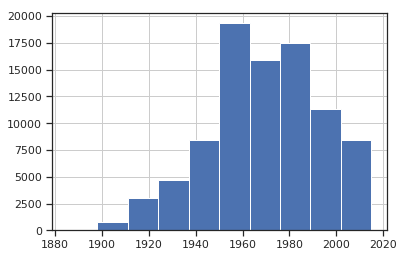

In [33]:
props['yearbuilt'].hist()

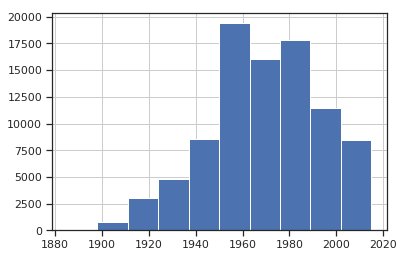

In [34]:
props_imputed['yearbuilt'].hist()

In [0]:
props = props_imputed.copy()

In [36]:
print('Total NaN values after imputation: {}'.format(props.isnull().values.sum()))

Total NaN values after imputation: 0


### 2.3 Normalização e discretização

In [0]:
# Salvar coluna de IDs
parcelid = props['parcelid'].copy()

#### 2.3.1 Discretização

In [38]:
props['taxvaluedollarcnt'].describe()

count    9.027500e+04
mean     4.576713e+05
std      5.548815e+05
min      2.200000e+01
25%      1.990235e+05
50%      3.428720e+05
75%      5.405890e+05
max      2.775000e+07
Name: taxvaluedollarcnt, dtype: float64

In [0]:
#props['tax_value_intervals'] = pd.qcut(props['taxvaluedollarcnt'], 20)

In [40]:
# Pyspark QuantileDiscretizer: Discretizar a coluna 'taxvaluedollarcnt'
props_spark = spark.createDataFrame(props,props.columns.values.tolist())
props_spark_result = QuantileDiscretizer(numBuckets=10, inputCol="taxvaluedollarcnt",outputCol="area_intervals").fit(props_spark).transform(props_spark)
props_spark_result.show()

+-----------+-----------+----------+--------------------+------+-----------+-----------+-------------+-----------------+-------------------------+---------------------+----------------------+------------+--------------+-----------+-------+---------+--------------------------+-----------------+---------------------+---------+-------------------+--------------------+----------------+-----------------+---------------+--------------+
|   parcelid|bathroomcnt|bedroomcnt|finishedsquarefeet12|  fips|fullbathcnt|   latitude|    longitude|lotsizesquarefeet|propertycountylandusecode|propertylandusetypeid|rawcensustractandblock|regionidcity|regionidcounty|regionidzip|roomcnt|yearbuilt|structuretaxvaluedollarcnt|taxvaluedollarcnt|landtaxvaluedollarcnt|taxamount|censustractandblock|            logerror|transaction_year|transaction_month|transaction_day|area_intervals|
+-----------+-----------+----------+--------------------+------+-----------+-----------+-------------+-----------------+------------

#### 2.3.2 Normalização

In [41]:
min_max_scaler = preprocessing.MinMaxScaler()
props = pd.DataFrame(min_max_scaler.fit_transform(props), columns=props.columns, index=props.index)

props.describe()

,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transaction_year,transaction_month,transaction_day
count,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,...,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.0,90275.000000,90275.000000
mean,0.014929,0.113974,0.189492,0.088176,0.160413,0.064484,0.451080,0.659818,0.004154,0.328767,...,0.642329,0.018031,0.016492,0.011360,0.018437,0.163493,0.494162,0.0,0.440895,0.511317
std,0.016450,0.050214,0.072277,0.045605,0.279236,0.050900,0.179429,0.190499,0.016640,0.334272,...,0.182748,0.021005,0.019996,0.016347,0.021246,0.277442,0.017242,0.0,0.255699,0.300286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.005568,0.100000,0.125000,0.059018,0.000000,0.052632,0.319793,0.547388,0.000800,0.038961,...,0.523077,0.008107,0.007171,0.003355,0.008772,0.004047,0.490227,0.0,0.272727,0.233333
50%,0.012057,0.100000,0.187500,0.076808,0.000000,0.052632,0.461975,0.673256,0.001034,0.129870,...,0.653846,0.013215,0.012355,0.007875,0.013959,0.007025,0.493577,0.0,0.454545,0.500000
75%,0.023093,0.150000,0.250000,0.104642,0.297297,0.105263,0.564393,0.806299,0.001960,0.727273,...,0.784615,0.021108,0.019480,0.014098,0.021285,0.296872,0.497131,0.0,0.636364,0.766667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [42]:
props.head()

,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transaction_year,transaction_month,transaction_day
0,0.041787,0.125,0.1875,0.063065,1.0,0.052632,0.653005,0.084857,0.000225,0.714286,...,0.776923,0.011559,0.006911,0.003131,0.006108,0.999907,0.503136,0.0,0.000000,0.866667
1,0.041887,0.050,0.1250,0.038729,1.0,0.000000,0.632195,0.131517,0.000538,0.727273,...,0.807692,0.014446,0.008636,0.003912,0.007867,0.999897,0.495055,0.0,0.181818,0.966667
2,0.041962,0.100,0.1875,0.054920,1.0,0.052632,0.678199,0.194541,0.000918,0.662338,...,0.546154,0.003369,0.001724,0.000580,0.001686,0.999886,0.493577,0.0,0.363636,0.866667
3,0.041975,0.075,0.1250,0.077557,1.0,0.000000,0.687349,0.196234,0.001038,0.649351,...,0.615385,0.004575,0.002266,0.000705,0.001969,0.999888,0.486876,0.0,0.454545,0.200000
4,0.042022,0.125,0.2500,0.120584,1.0,0.052632,0.627937,0.149224,0.000884,0.662338,...,0.761538,0.027835,0.019963,0.011305,0.018136,0.999896,0.499069,0.0,0.636364,0.233333


Recuperando os IDs que foram normalizados

In [0]:
props['parcelid'] = parcelid

### 2.4 [Limpeza de dados](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)

#### 2.4.1 Univariado

"The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.""

Colunas que possuem média menor que o desvio padrão apresentam forte indício de outliers.

In [44]:
outliers = props.loc[:, props.mean() < props.std()]
outliers_columns = outliers.columns.values
outliers_columns

array(['fips', 'lotsizesquarefeet', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidzip', 'roomcnt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock'],
      dtype=object)

fips                              AxesSubplot(0.125,0.71587;0.227941x0.16413)
lotsizesquarefeet              AxesSubplot(0.398529,0.71587;0.227941x0.16413)
propertycountylandusecode      AxesSubplot(0.672059,0.71587;0.227941x0.16413)
rawcensustractandblock           AxesSubplot(0.125,0.518913;0.227941x0.16413)
regionidcity                  AxesSubplot(0.398529,0.518913;0.227941x0.16413)
regionidzip                   AxesSubplot(0.672059,0.518913;0.227941x0.16413)
roomcnt                          AxesSubplot(0.125,0.321957;0.227941x0.16413)
structuretaxvaluedollarcnt    AxesSubplot(0.398529,0.321957;0.227941x0.16413)
taxvaluedollarcnt             AxesSubplot(0.672059,0.321957;0.227941x0.16413)
landtaxvaluedollarcnt               AxesSubplot(0.125,0.125;0.227941x0.16413)
taxamount                        AxesSubplot(0.398529,0.125;0.227941x0.16413)
censustractandblock              AxesSubplot(0.672059,0.125;0.227941x0.16413)
dtype: object

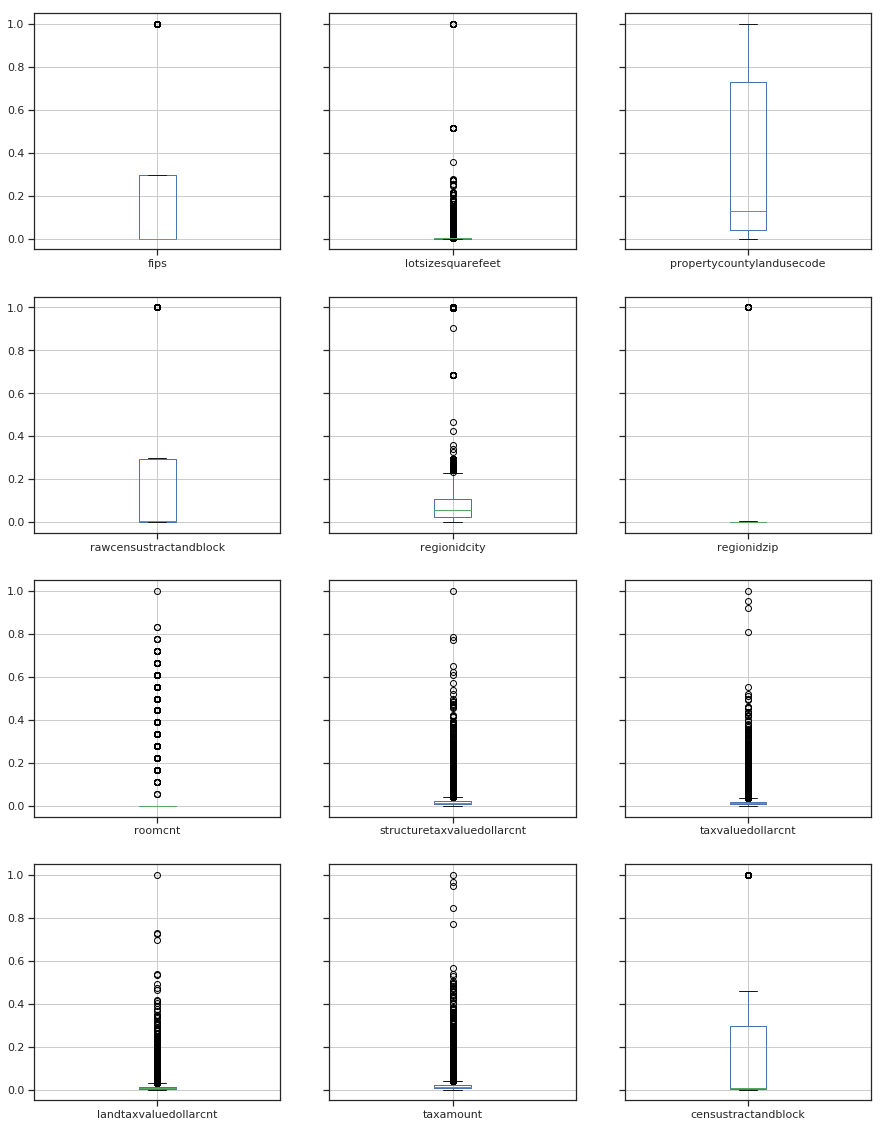

In [45]:
outliers.plot.box(subplots=True, layout=(4,3), sharey=True, figsize=(15,20), grid=True)

##### Remoção de outliers usando Z-score

In [46]:
print(outliers.shape)
outliers.describe()

(90275, 12)


,fips,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock
count,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000
mean,0.160413,0.004154,0.328767,0.163424,0.077520,0.001990,0.082140,0.018031,0.016492,0.011360,0.018437,0.163493
std,0.279236,0.016640,0.334272,0.277446,0.117887,0.012054,0.156646,0.021005,0.019996,0.016347,0.021246,0.277442
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000800,0.038961,0.002966,0.022785,0.000695,0.000000,0.008107,0.007171,0.003355,0.008772,0.004047
50%,0.000000,0.001034,0.129870,0.007021,0.055276,0.001353,0.000000,0.013215,0.012355,0.007875,0.013959,0.007025
75%,0.297297,0.001960,0.727273,0.296872,0.107135,0.003309,0.000000,0.021108,0.019480,0.014098,0.021285,0.296872
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
Z = np.abs(stats.zscore(outliers, axis=1, ddof=0))
outliers = outliers[(Z < 3).all(axis=1)]
print(outliers.shape)
outliers.describe()

(65532, 12)


,fips,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock
count,65532.000000,65532.000000,65532.000000,65532.000000,65532.000000,65532.000000,65532.000000,65532.000000,65532.000000,65532.000000,65532.000000,65532.000000
mean,0.220944,0.003843,0.402727,0.223153,0.061907,0.002069,0.113147,0.019676,0.018398,0.012851,0.020182,0.223187
std,0.306650,0.015116,0.356774,0.304975,0.042023,0.001336,0.174048,0.023722,0.022600,0.018451,0.023618,0.304961
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000069,0.000010,0.000000,0.000000
25%,0.000000,0.000784,0.038961,0.004100,0.022785,0.000836,0.000000,0.008394,0.008009,0.004120,0.009390,0.004102
50%,0.000000,0.001031,0.155844,0.011081,0.055276,0.001669,0.000000,0.014063,0.013465,0.008837,0.014804,0.011081
75%,0.297297,0.001754,0.766234,0.297159,0.091122,0.003339,0.277778,0.022708,0.021319,0.015546,0.023107,0.297159
max,1.000000,0.514856,1.000000,1.000000,1.000000,0.004485,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Remoção de outliers utilizando o IQR-score (Método Tukey)

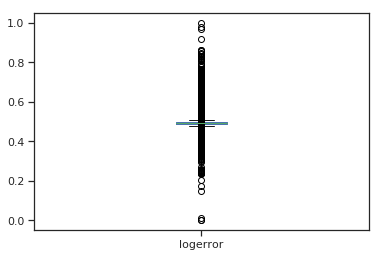

In [48]:
props['logerror'].plot.box()

In [0]:
def plotVariableDist (df, column):
  fig,ax = plt.subplots()
  fig.set_size_inches(15,5)
  sns.distplot(df[column].values, bins=50,color="#34495e",ax=ax)
  ax.set(xlabel=column, ylabel='VIF Score',title="Distribution Of Dependent Variable")

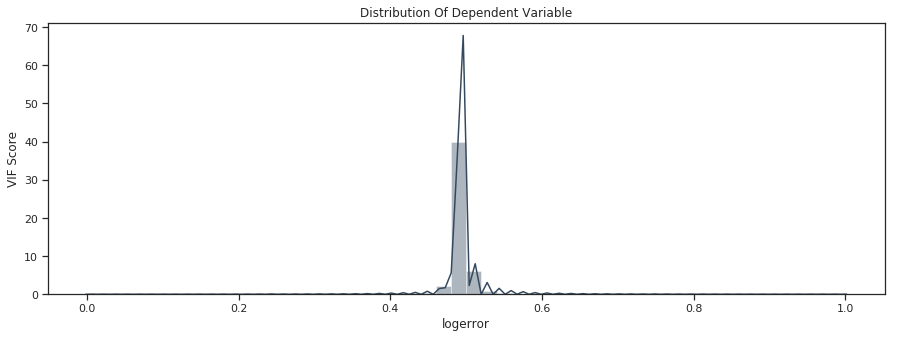

In [50]:
plotVariableDist(props, 'logerror')

In [0]:
def outlierRemovalIQR (df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  return df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [52]:
props_out = outlierRemovalIQR(props)
props_out.shape

(39042, 26)

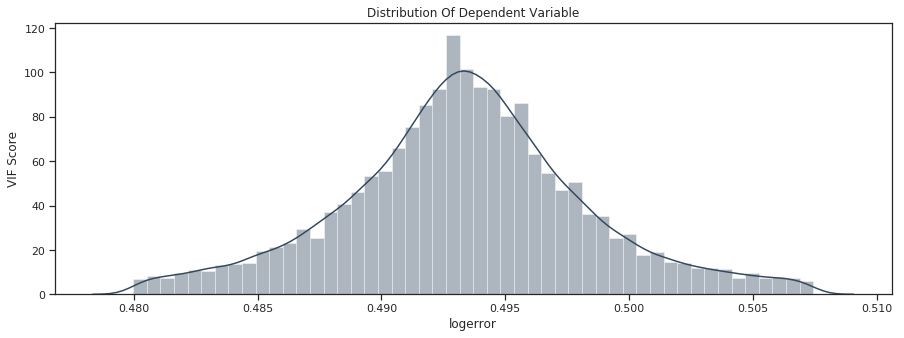

In [53]:
plotVariableDist(props_out, 'logerror')

#### 2.4.2 Bivariado

-  logerror com transaction_month
-  logerror com finishedsquarefeet12
-  logerror com yearbuilt
-  finishedsquarefeet12 com yearbuilt

##### Combinar as colunas yearbuilt e finishedsquarefeet12 para remoção de outliers Bivariado

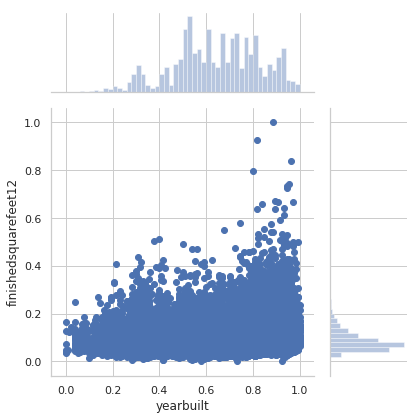

In [54]:
sns.set(style="whitegrid")
sns.jointplot(x="yearbuilt", y="finishedsquarefeet12", data=props, ratio=3)

In [0]:
props['area_yearbuilt'] = props['finishedsquarefeet12'] / props['yearbuilt']

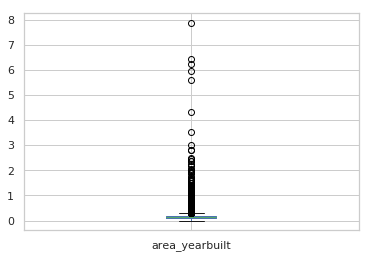

In [56]:
props['area_yearbuilt'].plot.box()

In [0]:
props['area_yearbuilt'].replace([np.inf, -np.inf], 0, inplace=True)


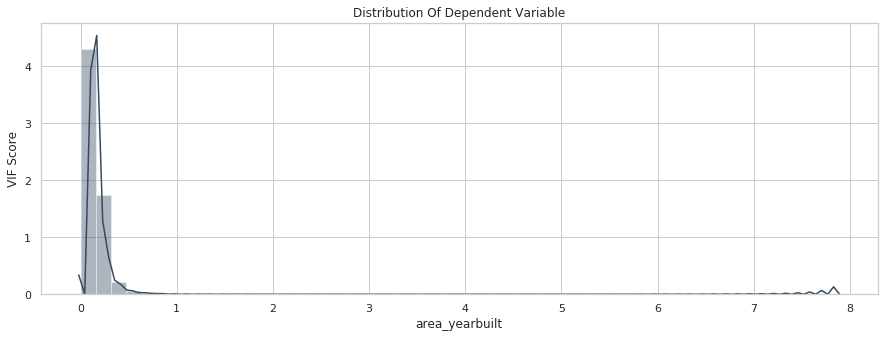

In [58]:
plotVariableDist(props, 'area_yearbuilt')

(38043,)


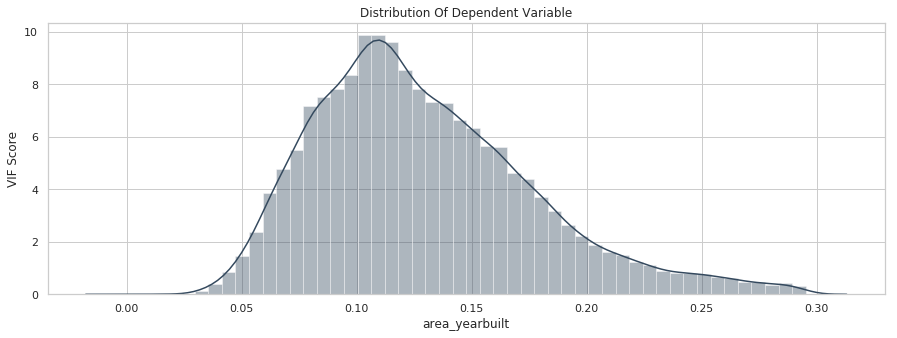

In [59]:
area_yearbuilt_out = outlierRemovalIQR(props)
print(area_yearbuilt_out.area_yearbuilt.shape)
plotVariableDist(area_yearbuilt_out, 'area_yearbuilt')


#### 2.4.3 Multivariado [1](https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html), [2](https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e), [3](https://)

##### Usando Isolation Forest para Detecção de outliers multivariados

In [60]:
rng = np.random.RandomState(42)
isolation_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=.04, max_features=props.shape[1])
isolation_forest.fit(props)
props['outlier'] = isolation_forest.predict(props)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [0]:
props_no_outlier = props[props['outlier'] != -1]

Comparação das estatísticas descritivas antes e depois da detecção de outliers

In [62]:
props.describe()

,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,...,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transaction_year,transaction_month,transaction_day,area_yearbuilt,outlier
count,9.027500e+04,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,...,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.0,90275.000000,90275.000000,90275.000000,90275.000000
mean,1.298466e+07,0.113974,0.189492,0.088176,0.160413,0.064484,0.451080,0.659818,0.004154,0.328767,...,0.016492,0.011360,0.018437,0.163493,0.494162,0.0,0.440895,0.511317,0.149975,0.920000
std,2.504510e+06,0.050214,0.072277,0.045605,0.279236,0.050900,0.179429,0.190499,0.016640,0.334272,...,0.019996,0.016347,0.021246,0.277442,0.017242,0.0,0.255699,0.300286,0.112938,0.391921
min,1.071174e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-1.000000
25%,1.155950e+07,0.100000,0.125000,0.059018,0.000000,0.052632,0.319793,0.547388,0.000800,0.038961,...,0.007171,0.003355,0.008772,0.004047,0.490227,0.0,0.272727,0.233333,0.093471,1.000000
50%,1.254734e+07,0.100000,0.187500,0.076808,0.000000,0.052632,0.461975,0.673256,0.001034,0.129870,...,0.012355,0.007875,0.013959,0.007025,0.493577,0.0,0.454545,0.500000,0.125878,1.000000
75%,1.422755e+07,0.150000,0.250000,0.104642,0.297297,0.105263,0.564393,0.806299,0.001960,0.727273,...,0.019480,0.014098,0.021285,0.296872,0.497131,0.0,0.636364,0.766667,0.174182,1.000000
max,1.629608e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,7.873669,1.000000


In [63]:
props_no_outlier.describe()

,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,...,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transaction_year,transaction_month,transaction_day,area_yearbuilt,outlier
count,8.666400e+04,86664.000000,86664.000000,86664.000000,86664.000000,86664.000000,86664.000000,86664.000000,86664.000000,86664.000000,...,86664.000000,86664.000000,86664.000000,86664.000000,86664.000000,86664.0,86664.000000,86664.000000,86664.000000,86664.0
mean,1.287866e+07,0.111381,0.187554,0.084582,0.139279,0.061814,0.448315,0.670269,0.004122,0.318559,...,0.014921,0.010277,0.016877,0.142447,0.494063,0.0,0.440908,0.511732,0.145542,1.0
std,2.442321e+06,0.044226,0.068358,0.037283,0.249551,0.045283,0.179404,0.179383,0.016432,0.333646,...,0.012400,0.010497,0.013706,0.247762,0.016697,0.0,0.255168,0.299871,0.106009,0.0
min,1.071174e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000007,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0
25%,1.153413e+07,0.100000,0.125000,0.058668,0.000000,0.052632,0.317344,0.556885,0.000795,0.038961,...,0.007095,0.003282,0.008714,0.002836,0.490227,0.0,0.272727,0.233333,0.092869,1.0
50%,1.251230e+07,0.100000,0.187500,0.075808,0.000000,0.052632,0.453947,0.679317,0.001024,0.129870,...,0.012143,0.007700,0.013752,0.006753,0.493470,0.0,0.454545,0.500000,0.124057,1.0
75%,1.416087e+07,0.150000,0.250000,0.101444,0.297297,0.105263,0.559963,0.808629,0.001883,0.727273,...,0.018800,0.013632,0.020649,0.296869,0.497035,0.0,0.636364,0.766667,0.170206,1.0
max,1.629608e+08,1.000000,1.000000,0.436360,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.183780,0.203995,0.537981,1.000000,1.000000,0.0,1.000000,1.000000,7.873669,1.0


In [0]:
props = props_no_outlier.copy()

## Criação de Novas Features

## Visualização de Dados

#### Distribuição da localização das propriedades

In [0]:
props['latitude'] /= 1e6
props['longitude'] /= 1e6

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

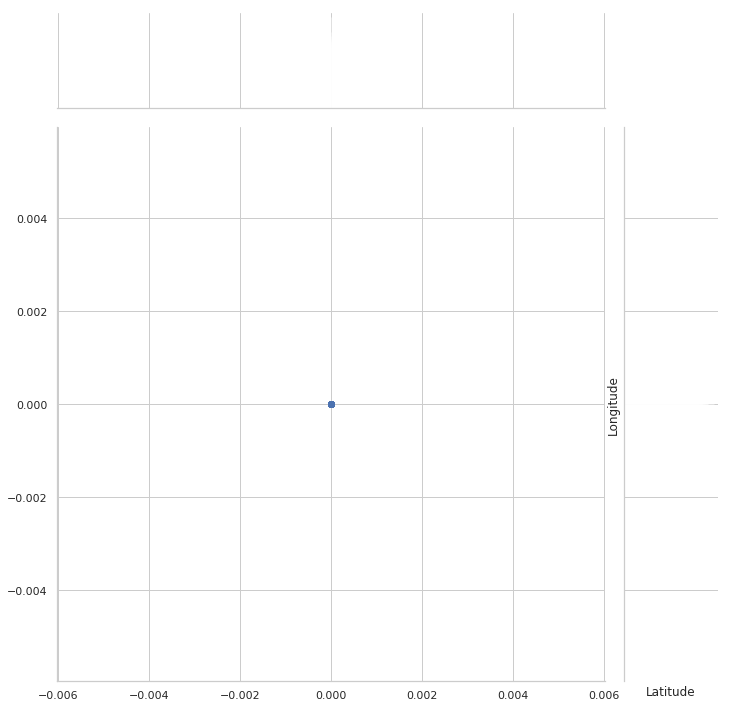

In [66]:
plt.figure(figsize=(12,12))
sns.jointplot(x=props.latitude.values, y=props.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

In [0]:
#Save for later

#Get all null columns as dataframe 
#print(props[props.isnull().any(axis=1)][nan_columns].head())

#props_train = pd.merge(props, train, on='parcelid', how='left')

#msno.dendrogram(props)

# Changing type of columns with Ids to unsigned short int
#id_columns = props.filter(regex='id').columns.values
#props[id_columns] = props[id_columns].astype('uint16')

# Par0s['propertyzoningdesc'] = cat_df_props['propertyzoningdesc'].cat.codes.astype('int16')

#msno.heatmap(props[nan_columns], figsize=(15,15))
# All Columns Correlation
#f,ax = plt.subplots(figsize=(15, 15))
#sns.heatmap(props.corr(), annot=True, linewidths=.5, fmt='.1f',ax=ax)
#plt.show()

###############################################################################################################################

# b = abs(props.drop(['parcelid'], axis=1).mean() - props.drop(['parcelid'], axis=1).median()).nlargest(5)

#Para excluir

# Não podemos usar o one hot encoder pois precisariamos criar 240 novas colunas para um dataframe com 3 mi instâncias
#cat_df_props['propertycountylandusecode'].cat.categories

#prop_county_land_use_code = cat_df_props['propertycountylandusecode'].cat.codes
#prop_county_land_use_code

#lb_make = LabelEncoder()
#cat_df_props['propertycountylandusecode'] = lb_make.fit_transform(cat_df_props['propertycountylandusecode'])

# Algumas estatísticas Descritivas

In [0]:
imputed = pd.read_csv('https://raw.githubusercontent.com/thiagotandrade/ds_project/master/Database/props_imputed_v2.csv',header=0, sep=',', quotechar='"')

In [69]:
imputed.describe()

,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transaction_year,transaction_month,transaction_day
count,9.027500e+04,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,9.027500e+04,9.027500e+04,9.027500e+04,90275.000000,...,90275.000000,9.027500e+04,9.027500e+04,9.027500e+04,90275.000000,9.027500e+04,90275.000000,90275.0,90275.000000,90275.000000
mean,1.298466e+07,2.279474,3.031869,1766.497488,6048.870551,2.225189,3.400541e+07,-1.181989e+08,2.912494e+04,24.315071,...,1968.502799,1.794753e+05,4.576713e+05,2.783341e+05,5983.760300,6.049185e+13,0.011457,2016.0,5.849848,16.339507
std,2.504510e+06,1.004271,1.156436,912.601389,20.663461,0.967107,2.649654e+05,3.606032e+05,1.159982e+05,25.738982,...,23.757301,2.089603e+05,5.548815e+05,4.004934e+05,6838.704246,2.050521e+11,0.161079,0.0,2.812690,9.008589
min,1.071174e+07,0.000000,0.000000,2.000000,6037.000000,1.000000,3.333930e+07,-1.194479e+08,1.670000e+02,-1.000000,...,1885.000000,1.000000e+02,2.200000e+01,2.200000e+01,49.080000,6.037101e+13,-4.605000,2016.0,1.000000,1.000000
25%,1.155950e+07,2.000000,2.000000,1183.000000,6037.000000,2.000000,3.381154e+07,-1.184117e+08,5.741000e+03,2.000000,...,1953.000000,8.074700e+04,1.990235e+05,8.222800e+04,2872.600000,6.037400e+13,-0.025300,2016.0,4.000000,8.000000
50%,1.254734e+07,2.000000,3.000000,1539.000000,6037.000000,2.000000,3.402150e+07,-1.181734e+08,7.375000e+03,9.000000,...,1970.000000,1.315660e+05,3.428720e+05,1.929600e+05,4542.440000,6.037620e+13,0.006000,2016.0,6.000000,16.000000
75%,1.422755e+07,3.000000,4.000000,2096.000000,6059.000000,3.000000,3.417274e+07,-1.179216e+08,1.382729e+04,55.000000,...,1987.000000,2.100780e+05,5.405890e+05,3.454150e+05,6900.600000,6.059042e+13,0.039200,2016.0,8.000000,24.000000
max,1.629608e+08,20.000000,16.000000,20013.000000,6111.000000,20.000000,3.481601e+07,-1.175549e+08,6.971010e+06,76.000000,...,2015.000000,9.948100e+06,2.775000e+07,2.450000e+07,321936.090000,6.111009e+13,4.737000,2016.0,12.000000,31.000000


In [70]:
imputed.shape

(90275, 26)

In [71]:
imputed.axes

[RangeIndex(start=0, stop=90275, step=1),
 Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'fips',
        'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
        'propertycountylandusecode', 'propertylandusetypeid',
        'rawcensustractandblock', 'regionidcity', 'regionidcounty',
        'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
        'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount',
        'censustractandblock', 'logerror', 'transaction_year',
        'transaction_month', 'transaction_day'],
       dtype='object')]

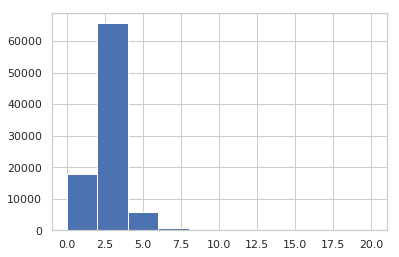

In [72]:
imputed['bathroomcnt'].hist()

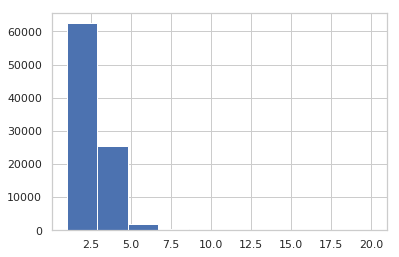

In [73]:
imputed['fullbathcnt'].hist()

In [74]:
print(f"Média/Mediana de banheiros completos {imputed['fullbathcnt'].mean()}/{imputed['fullbathcnt'].median()} média de banheiros incompletos {imputed['bathroomcnt'].mean()}/{imputed['bathroomcnt'].median()}")

Média/Mediana de banheiros completos 2.225188701190806/2.0 média de banheiros incompletos 2.2794738299639987/2.0


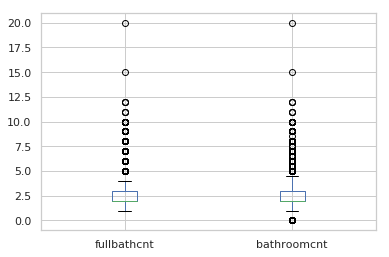

In [75]:
imputed.boxplot(column=['fullbathcnt','bathroomcnt'])

In [0]:
#apaguei sem querer o q mostrava a correlação de fullbathcnt com bathroom cnt q na verdade deveria ser bedroomcnt
cnt_transaction = imputed.groupby('transaction_month')['transaction_month'].count()

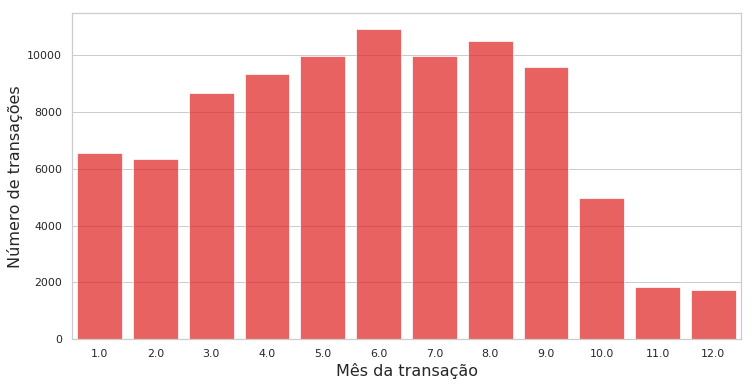

In [77]:
#acho que essas análises deveriam ser feitas antes da remoção dos nulos
cnt_transaction = imputed.groupby('transaction_month')['transaction_month'].count()
plt.figure(figsize=(12,6))
sns.barplot(cnt_transaction.index, cnt_transaction.values, alpha=0.7,color = 'red')
plt.xlabel("Mês da transação",fontsize=16)
plt.ylabel("Número de transações",fontsize=16)
plt.show()

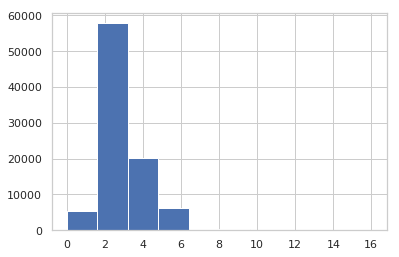

In [78]:
#Número de banheiro com número de quartos
imputed['bedroomcnt'].hist()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


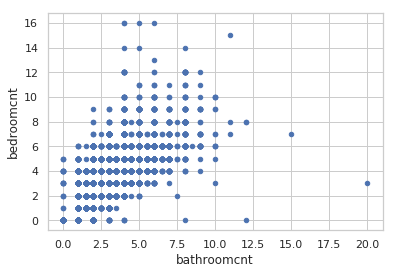

In [79]:
imputed.plot.scatter(x='bathroomcnt',y='bedroomcnt')

# Testes de Hipóteses

testar se o ano das casas segue a mesma distribuição da área

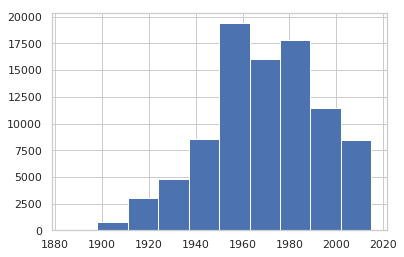

In [80]:
imputed['yearbuilt'].hist()

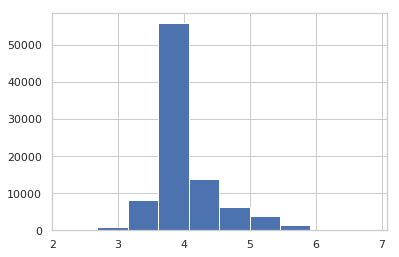

In [81]:
imputed['lotsize_log10'] = imputed['lotsizesquarefeet'].apply(np.log10)
imputed['lotsize_log10'].hist()

In [82]:
#testando se as variáveis seguem distribuição normal
stats.shapiro(imputed['yearbuilt'])

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9824066758155823, 0.0)

In [83]:
#o teste de Shapiro não funciona com N > 5000 e o normaltest tinha p_value 0.0
stats.skewtest(imputed['yearbuilt'])

SkewtestResult(statistic=-36.06747476858066, pvalue=7.340693551179111e-285)

In [84]:
stats.skewtest(imputed['lotsize_log10'])

SkewtestResult(statistic=137.16865970640646, pvalue=0.0)

In [85]:
#'yearbuilt' e 'lotsize_log10' não seguem distribuição normal
#teste a ser usado --> mannwhitneyu
stats.mannwhitneyu(imputed['yearbuilt'],imputed['lotsize_log10'],alternative = 'two-sided')

MannwhitneyuResult(statistic=8149575625.0, pvalue=0.0)

In [86]:
#Testando só pra ver se o pvalue muda (teoricamente esse teste n deve ser feito já q as distribuições n seguem a normal)
stats.ttest_ind(imputed['yearbuilt'],imputed['lotsizesquarefeet'])

Ttest_indResult(statistic=-70.34049493020676, pvalue=0.0)

In [87]:
#testando a correlação entre as variáveis já q o p_value ficou 0.0 nos testes acima
imputed['yearbuilt'].corr(imputed['lotsize_log10'])

0.24210254732002376

In [88]:
imputed['yearbuilt'].corr(imputed['lotsizesquarefeet'],method='pearson')

0.11121102836443442

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


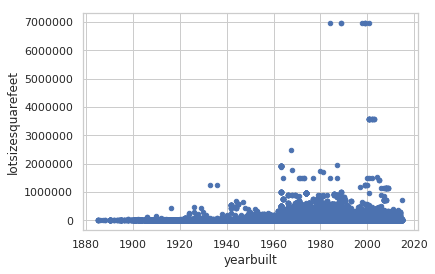

In [89]:
imputed.plot.scatter(x='yearbuilt',y='lotsizesquarefeet')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


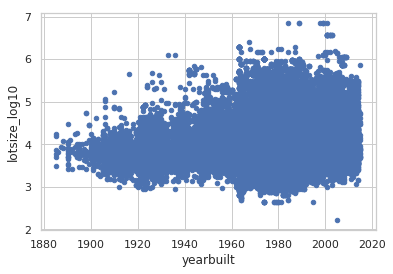

In [90]:
imputed.plot.scatter(x='yearbuilt',y='lotsize_log10')

In [0]:
#imposto() com a área 